<a href="https://www.kaggle.com/code/imokutmfonudoh/resnet-for-ecg-covid-ipynb?scriptVersionId=228847411" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Final code to build and compare resnet and autoencoder models to predict covid 19 using Electrocardiogram (ECG) data from wearable devices

## Import needed libraries and basic setup

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, Activation
from tensorflow.keras.layers import Add, GlobalAveragePooling1D, Reshape, Flatten, Dropout
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Functions to load and preprocess data

In [3]:
# Load and preprocess data
def load_data(file_path):
    """
    Load ECG data from CSV file
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        X: ECG signals
        y: Labels
    """
    df = pd.read_csv(file_path, header=None)
    
    # Assuming the last column contains the labels
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    y = np.where(y==4, 1, 0)
    return X, y

In [4]:
# Data preprocessing
def preprocess_data(X, y, X_test, y_test, validation_size=0.2):
    """
    Preprocess data: normalize signals and split into train/validation/test sets
    
    Args:
        X: ECG signals
        y: Labels
        X_test: ECG signals for testing
        y_test: Test labels
        test_size: Proportion of data for test set
        validation_size: Proportion of training data for validation set
        
    Returns:
        X_train, X_val, X_test: Preprocessed signal data
        y_train, y_val, y_test: Labels
    """

    # Split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size, 
                                                        random_state=42, stratify=y)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Reshape for Conv1D layers: (batch_size, signal_length, channels)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Convert labels to categorical (one-hot encoding)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"COVID samples in test set: {np.sum(y_test[:, 1])}")
    print(f"Non-COVID samples in test set: {np.sum(y_test[:, 0])}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

## Function to build RESNET

In [5]:
# 2. ResNet Model
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """
    Create a residual block for ResNet
    
    Args:
        x: Input tensor
        filters: Number of filters for Conv1D layers
        kernel_size: Size of the kernel
        stride: Stride for the first Conv1D layer
        
    Returns:
        Output tensor for the residual block
    """
    if conv_shortcut:
        shortcut = Conv1D(
            filters, 1, strides=stride, padding='same', name=f'{name}_0_conv'
        )(x)
        shortcut = BatchNormalization(name=f'{name}_0_bn')(shortcut)
    else:
        shortcut = x
    
    # First convolution layer
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', name=f'{name}_1_conv')(x)
    x = BatchNormalization(name=f'{name}_1_bn')(x)
    x = Activation('relu', name=f'{name}_1_relu')(x)
    
    # Second convolution layer
    x = Conv1D(filters, kernel_size, padding='same', name=f'{name}_2_conv')(x)
    x = BatchNormalization(name=f'{name}_2_bn')(x)
    
    # Add shortcut to output
    x = Add(name=f'{name}_add')([shortcut, x])
    x = Activation('relu', name=f'{name}_out')(x)
    
    return x

In [6]:
def build_resnet(input_shape):
    """
    Build a ResNet model for ECG signal classification
    
    Args:
        input_shape: Shape of input signal (signal_length, channels)
        
    Returns:
        model: compiled ResNet model
    """
    inputs = Input(shape=input_shape, name='input')
    
    # Initial convolution
    x = Conv1D(64, 7, strides=2, padding='same', name='conv1_conv')(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = layers.MaxPooling1D(3, strides=2, padding='same', name='pool1_pool')(x)

    # Residual blocks
    x = residual_block(x, 64, name='conv2_block1')
    x = residual_block(x, 64, conv_shortcut=False, name='conv2_block2')
    
    x = residual_block(x, 128, stride=2, name='conv3_block1')
    x = residual_block(x, 128, conv_shortcut=False, name='conv3_block2')
    
    x = residual_block(x, 256, stride=2, name='conv4_block1')
    x = residual_block(x, 256, conv_shortcut=False, name='conv4_block2')
    
    # Global average pooling and dense layer
    x = layers.GlobalAveragePooling1D(name='avg_pool')(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = models.Model(inputs, outputs, name='resnet_ecg')
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Functions for model training and evaluation


In [7]:
# Training procedure
def train_model(model, X_train, X_val, y_train, y_val, batch_size=32, epochs=10, patience=3):
    """
    Train both autoencoder and ResNet models
    
    Args:
        X_train, X_val: Training and validation signals
        y_train, y_val: Training and validation labels
        input_shape: Shape of input signals
        batch_size: Batch size for training
        epochs: Maximum number of epochs
        patience: Patience for early stopping
        
    Returns:
        trained_model: Dictionary containing trained model and training history
    """
    # callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience//2, min_lr=1e-6, verbose=1)
    ]
    
    # Train ResNet
    print("Training ResNet...")
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [8]:
# Evaluate models
def evaluate_model(model, X_test, y_test, class_names=['Non-COVID', 'COVID']):
    """
    Evaluate models on test data
    
    Args:
        models: Dictionary containing trained models
        X_test: Test signals
        y_test: Test labels
        class_names: Names of the classes
        
    Returns:
        results: Dictionary containing evaluation metrics
    """
        
    # Evaluate Metrics
    print("\nEvaluating ResNet...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"ResNet - Test Accuracy: {accuracy:.4f}")
    
    # Generate predictions
    resnet_preds = model.predict(X_test)
    y_pred = np.argmax(resnet_preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Classification reports
    report = classification_report(y_true, y_pred,
                                         target_names=class_names ,output_dict=True)
    
    # Confusion matrices
    cm = confusion_matrix(y_true, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ =roc_curve(y_true, resnet_preds[:, 1])
    roc_auc = auc(fpr, tpr)

    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, resnet_preds[:, 1])

    # Compile results
    results = {
        'accuracy': accuracy,
        'loss': loss,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc_curve': {
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        },
        'pr_curve': {
            'precision': precision,
            'recall': recall
        },
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': resnet_preds
    }
    
    
    return results

## Visualization functions

In [9]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss.
    
    Args:
        history: Training history from model.fit()
    
    Returns:
        fig: Matplotlib figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy', fontsize=18)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss', fontsize=18)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig

In [10]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot confusion matrix.
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
    
    Returns:
        fig: Matplotlib figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot confusion matrix
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax
    )
    
    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Add text annotations for metrics
    plt.figtext(0.5, 0.01, f"Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}\n"
                           f"PPV: {ppv:.3f}, NPV: {npv:.3f}", 
                ha="center", fontsize=12, 
                bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    ax.set_title('Confusion Matrix', fontsize=18)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

In [11]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """
    Plot ROC curve.
    
    Args:
        fpr: False positive rate
        tpr: True positive rate
        roc_auc: Area under the ROC curve
    
    Returns:
        fig: Matplotlib figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
    
    # Plot random classifier line
    ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig

In [12]:
def plot_precision_recall_curve(precision, recall):
    """
    Plot precision-recall curve.
    
    Args:
        precision: Array of precision values
        recall: Array of recall values
    
    Returns:
        fig: Matplotlib figure
    """
    pr_auc = auc(recall, precision)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot PR curve
    ax.plot(recall, precision, label=f'AUC = {pr_auc:.3f}', linewidth=2)
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('Precision-Recall Curve', fontsize=18)
    ax.legend(loc="lower left", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig

In [13]:
def plot_sample_ecg_signals(X, y, class_names, n_samples=3):
    """
    Plot sample ECG signals from each class.
    
    Args:
        X: ECG signal data (shaped for the model)
        y: Labels (one-hot encoded)
        class_names: List of class names
        n_samples: Number of samples to plot per class
    
    Returns:
        fig: Matplotlib figure
    """
    # Convert one-hot encoded y to class indices
    y_idx = np.argmax(y, axis=1)
    
    fig, axes = plt.subplots(len(class_names), n_samples, figsize=(15, 3*len(class_names)))
    
    for i, class_idx in enumerate(range(len(class_names))):
        # Find samples of this class
        indices = np.where(y_idx == class_idx)[0]
        
        # If not enough samples, use whatever is available
        n_available = min(n_samples, len(indices))
        selected_indices = indices[:n_available]
        
        for j, idx in enumerate(selected_indices):
            # Reshape signal for plotting
            signal = X[idx].reshape(-1)
            
            # Plot the signal
            if len(class_names) > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
                
            ax.plot(signal)
            ax.set_title(f'{class_names[class_idx]} - Sample {j+1}')
            ax.set_ylim([-3, 3])  # Adjust as needed
            ax.grid(True, linestyle='--', alpha=0.6)
            
            # Remove x and y ticks for cleaner plots
            ax.set_xticks([])
            
            # Only keep y-ticks for leftmost plots
            if j > 0:
                ax.set_yticks([])
    
    plt.tight_layout()
    return fig

In [14]:
def generate_all_visualizations(history, evaluation_results, X_train, y_train, X_test, y_test, model, 
                              class_names=['Non-COVID', 'COVID'], output_dir='figures'):
    """
    Generate and save all visualizations for the paper.
    
    Args:
        history: Training history
        evaluation_results: Results from evaluate_model()
        X_train, y_train: Training data and labels
        X_test, y_test: Test data and labels
        model: Trained model
        class_names: List of class names
        output_dir: Directory to save the figures
    
    Returns:
        None
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Training history
    fig_history = plot_training_history(history)
    fig_history.savefig(os.path.join(output_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
    
    # 2. Confusion matrix
    fig_cm = plot_confusion_matrix(evaluation_results['confusion_matrix'], class_names)
    fig_cm.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    
    # 3. ROC curve
    fig_roc = plot_roc_curve(
        evaluation_results['roc_curve']['fpr'],
        evaluation_results['roc_curve']['tpr'],
        evaluation_results['roc_curve']['auc']
    )
    fig_roc.savefig(os.path.join(output_dir, 'roc_curve.png'), dpi=300, bbox_inches='tight')
    
    # 4. Precision-Recall curve
    fig_pr = plot_precision_recall_curve(
        evaluation_results['pr_curve']['precision'],
        evaluation_results['pr_curve']['recall']
    )
    fig_pr.savefig(os.path.join(output_dir, 'precision_recall_curve.png'), dpi=300, bbox_inches='tight')
    
    # 5. Sample ECG signals
    fig_samples_train = plot_sample_ecg_signals(X_train, y_train, class_names)
    fig_samples_train.savefig(os.path.join(output_dir, 'sample_ecg_signals_train.png'), dpi=300, bbox_inches='tight')
    
    fig_samples_test = plot_sample_ecg_signals(X_test, y_test, class_names)
    fig_samples_test.savefig(os.path.join(output_dir, 'sample_ecg_signals_test.png'), dpi=300, bbox_inches='tight')
    
    
    print(f"All visualizations saved to {output_dir}")

In [15]:
# Load data
print("Loading and preprocessing data...")
train_path = '/kaggle/input/ecg-heartbeat-covid-19/heartbeat_125_lead_ii_train_validation_dataset.csv'
test_path = '/kaggle/input/ecg-heartbeat-covid-19/heartbeat_125_lead_ii_test_dataset.csv'
X, y = load_data(train_path)
X_test, y_test = load_data(test_path)

Loading and preprocessing data...


In [16]:
# Define parameters
SIGNAL_LENGTH = X.shape[1]
num_classes = 2 

In [17]:
# Preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(X, y, X_test, y_test)
input_shape = (SIGNAL_LENGTH, 1)

Training set: 1265472 samples
Validation set: 316368 samples
Test set: 89770 samples
COVID samples in test set: 17954.0
Non-COVID samples in test set: 71816.0


In [18]:
# Build model
print("\nBuilding RESNET model...")
model = build_resnet(input_shape)
model.summary()


Building RESNET model...


Model: "resnet_ecg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 106, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv1D)       │ (None, 53, 64)         │            512 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 53, 64)         │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 53, 64)         │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling1D) │ (None, 27, 64)         │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 27, 64)         │         12,352 │ pool1_pool[0][0]       │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 27, 64)         │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 27, 64)         │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 27, 64)         │          4,160 │ pool1_pool[0][0]       │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 27, 64)         │         12,352 │ conv2_block1_1_relu[0… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 27, 64)         │            256 │ conv2_block1_0_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 27, 64)         │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_add (Add)    │ (None, 27, 64)         │              0 │ conv2_block1_0_bn[0][… │
│                           │                        │                │ conv2_block1_2_bn[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_out          │ (None, 27, 64)         │              0 │ conv2_block1_add[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_1_conv  

 Total params: 1,098,946 (4.19 MB)

 Trainable params: 1,094,338 (4.17 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [19]:
output_dir='results'
# Create output directory
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'figures'), exist_ok=True)

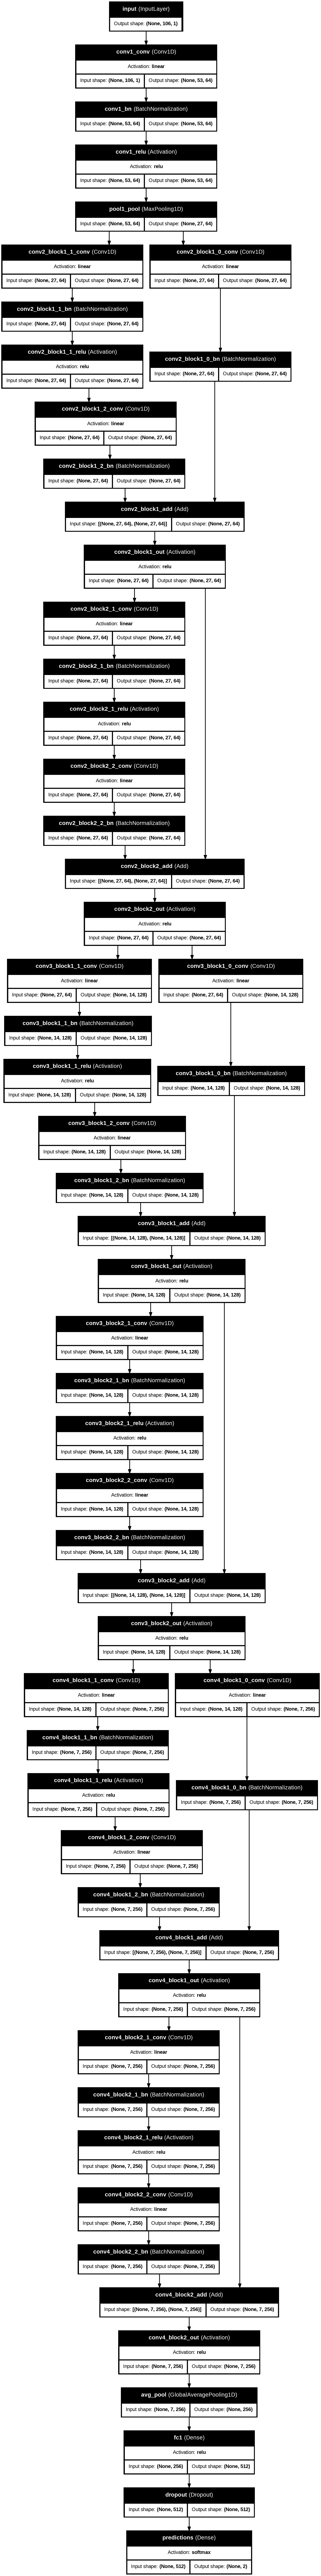

In [20]:
tf.keras.utils.plot_model(
        model, 
        to_file=os.path.join(output_dir, 'figures', 'model_architecture.png'),
        show_shapes=True, 
        show_layer_names=True,
        show_layer_activations=True,
        expand_nested=True,
        rankdir='TB'
    )

In [21]:
# Train model
print("\n Training model...")
model, history = train_model(model, X_train, X_val, y_train, y_val, epochs=20, batch_size=32)


 Training model...
Training ResNet...
Epoch 1/20
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 251s 6ms/step - accuracy: 0.8981 - loss: 0.2612 - val_accuracy: 0.9534 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 2/20
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 230s 6ms/step - accuracy: 0.9566 - loss: 0.1157 - val_accuracy: 0.9529 - val_loss: 0.1223 - learning_rate: 0.0010
Epoch 3/20
39541/39546 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9682 - loss: 0.0852
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 229s 6ms/step - accuracy: 0.9682 - loss: 0.0852 - val_accuracy: 0.8836 - val_loss: 0.3482 - learning_rate: 0.0010
Epoch 4/20
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 230s 6ms/step - accuracy: 0.9801 - loss: 0.0533 - val_accuracy: 0.9795 - val_loss: 0.0597 - learning_rate: 2.0000e-04
Epoch 5/20
39540/39546 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9854 - loss: 0.0391
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
39

In [22]:
# 4. Evaluate models
print("\nEvaluating model...")
evaluation_results = evaluate_model(model, X_test, y_test)


Evaluating model...

Evaluating ResNet...
ResNet - Test Accuracy: 0.9981
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [23]:
 # Print evaluation metrics
print(f"Test accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Test loss: {evaluation_results['loss']:.4f}")
print(f"ROC AUC: {evaluation_results['roc_curve']['auc']:.4f}")
print("\nClassification Report:")
print(classification_report(
    evaluation_results['y_true'], 
    evaluation_results['y_pred'],
    target_names=['Non-COVID', 'COVID']
))

Test accuracy: 0.9981
Test loss: 0.0086
ROC AUC: 0.9999

Classification Report:
              precision    recall  f1-score   support

   Non-COVID       1.00      1.00      1.00     71816
       COVID       0.99      1.00      1.00     17954

    accuracy                           1.00     89770
   macro avg       1.00      1.00      1.00     89770
weighted avg       1.00      1.00      1.00     89770



Generating visualizations...
All visualizations saved to results/figures


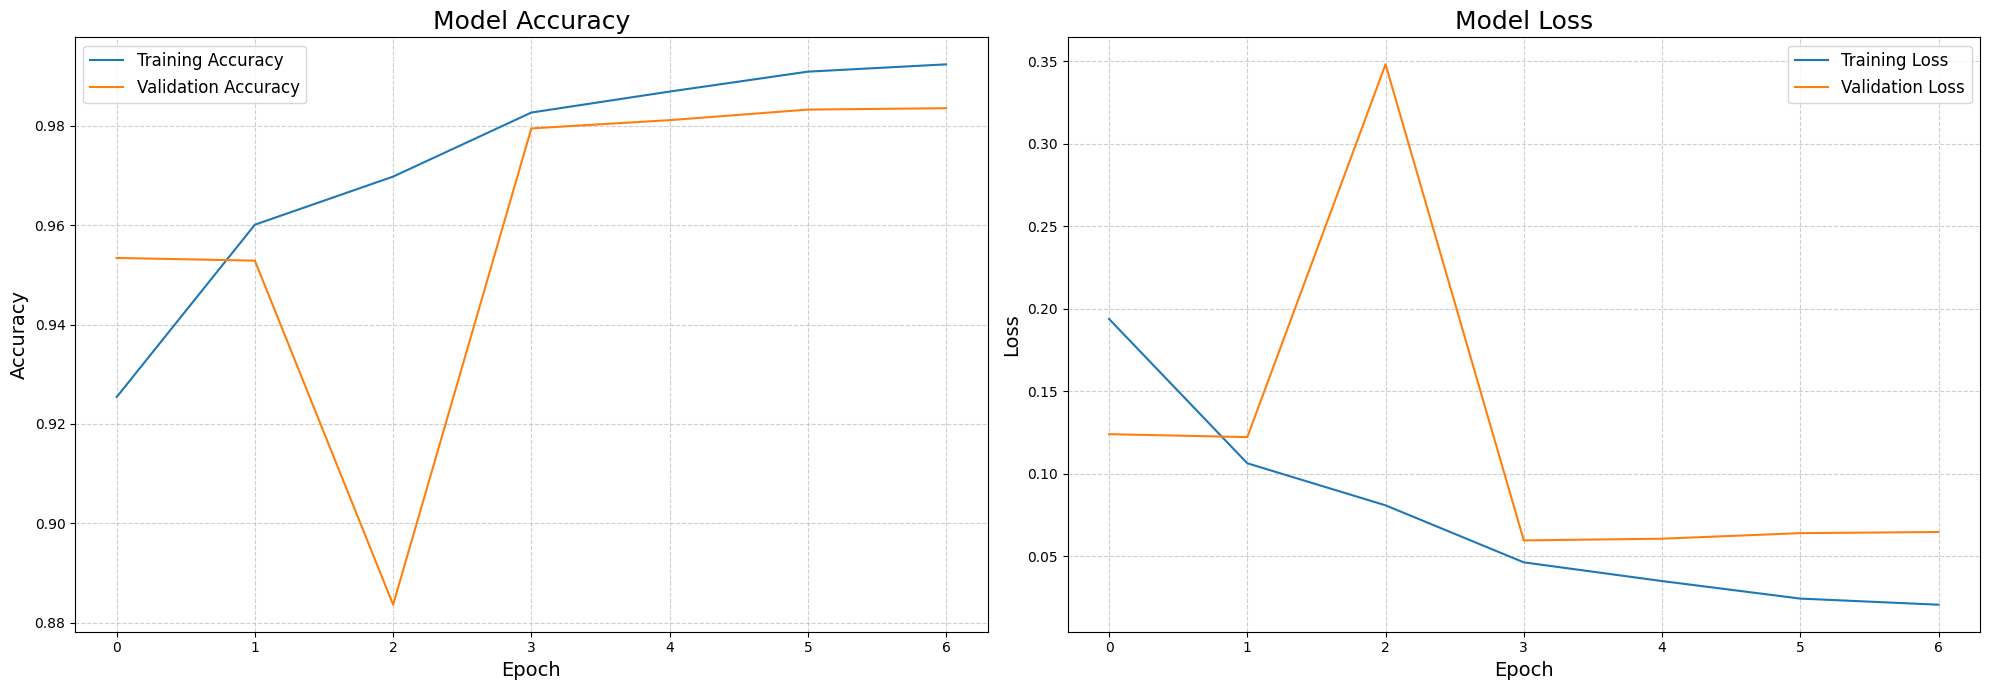

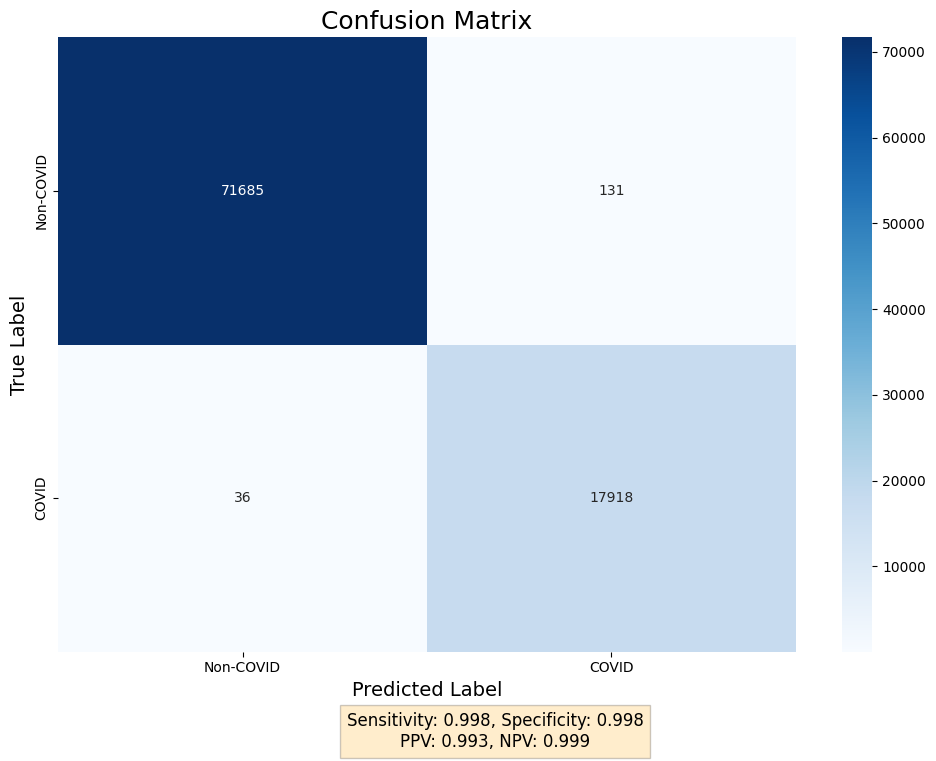

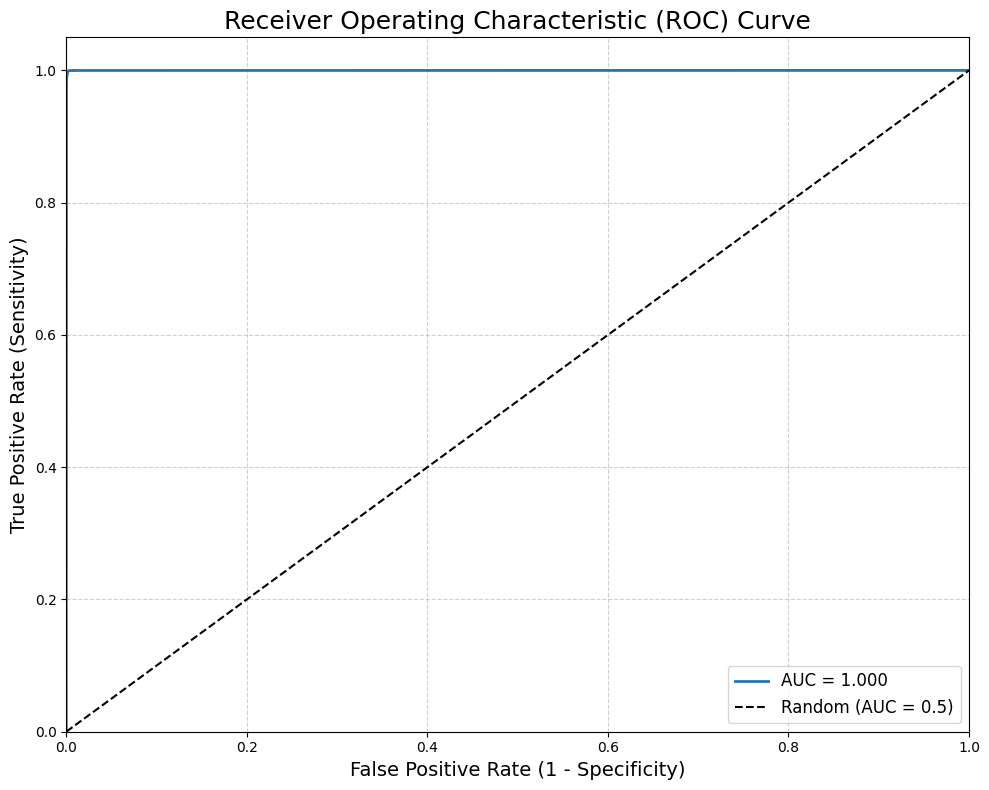

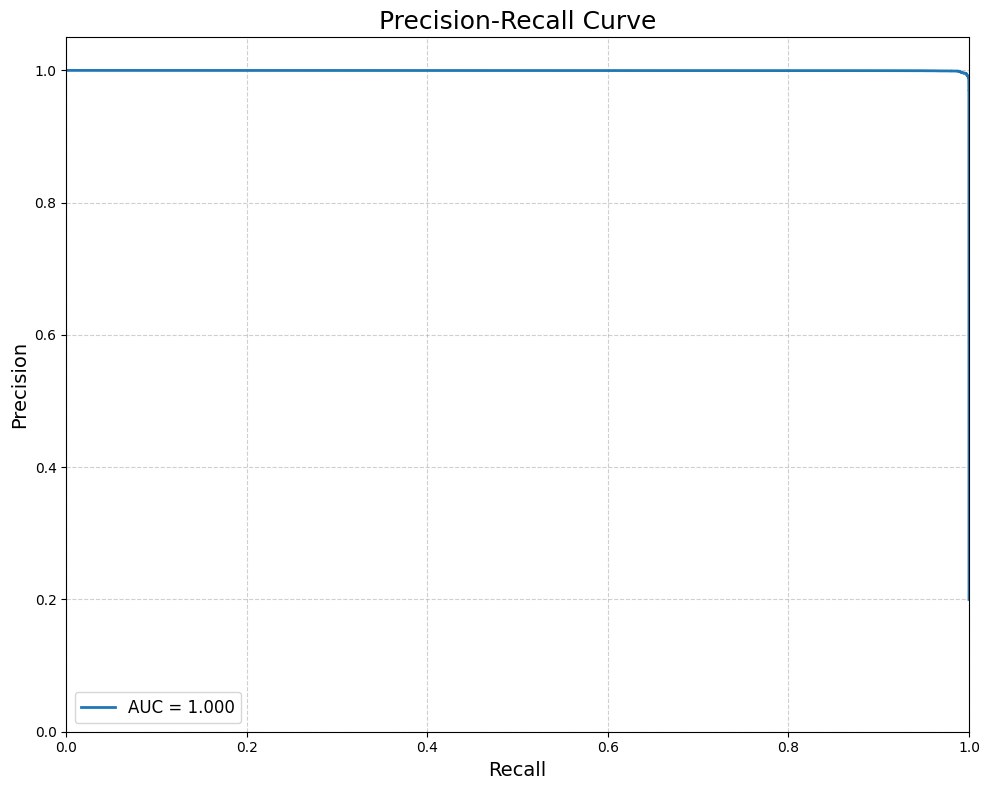

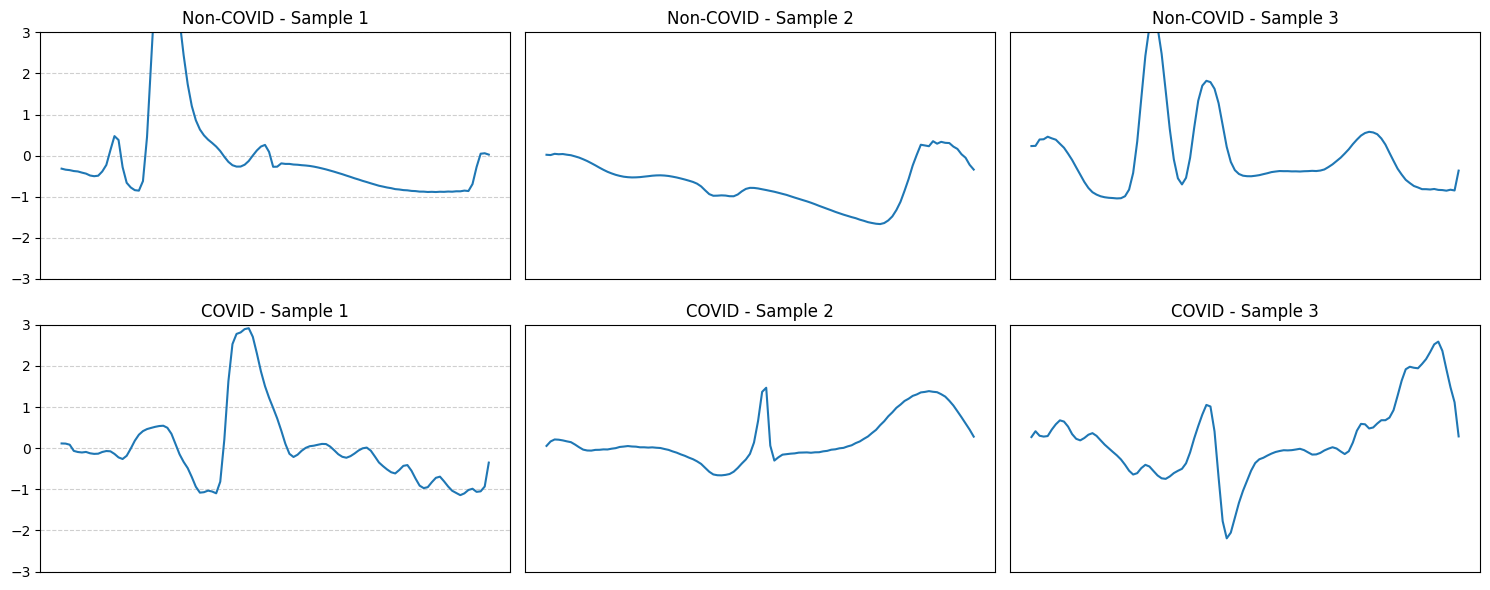

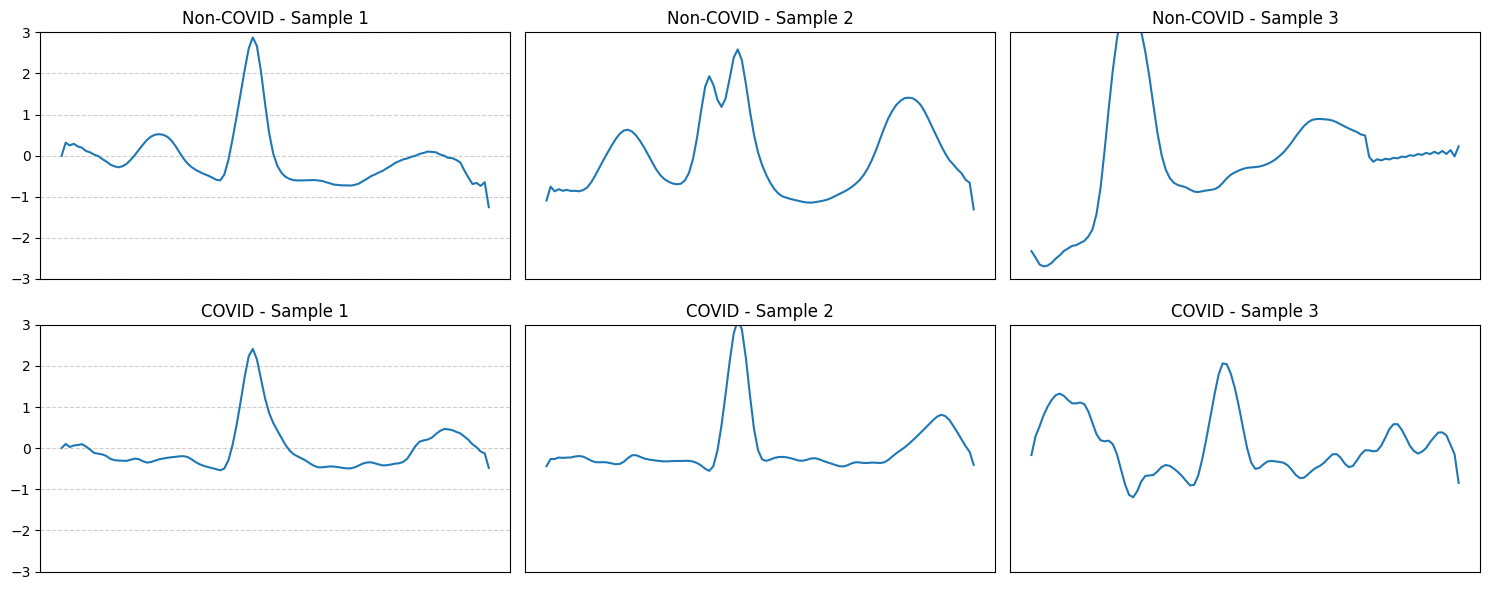

In [24]:
 # 5. Generate visualizations
print("Generating visualizations...")
generate_all_visualizations(
    history,
    evaluation_results,
    X_train, y_train,
    X_test, y_test,
    model,
    output_dir=os.path.join(output_dir, 'figures')
)

In [25]:
# 6. Save model and results
model.save(os.path.join(output_dir, 'covid_ecg_model.h5'))

In [26]:
# Save evaluation metrics to JSON
import json

# Convert numpy arrays to lists for JSON serialization
json_results = {
    'accuracy': float(evaluation_results['accuracy']),
    'loss': float(evaluation_results['loss']),
    'confusion_matrix': evaluation_results['confusion_matrix'].tolist(),
    'classification_report': evaluation_results['classification_report'],
    'roc_auc': float(evaluation_results['roc_curve']['auc'])
}

with open(os.path.join(output_dir, 'evaluation_results.json'), 'w') as f:
    json.dump(json_results, f, indent=4)